# Mean Variance Optimization

* We will use cvxopt as our QP solver and do MVO over a set of stocks with and without shorting allowed
* Let's look at Walmart, ExxonMobil, IBM, and GE

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cvxopt
import datetime

# Data handler from before
from data_handler import data_handler

# Hide the printouts from the solver
cvxopt.solvers.options['show_progress'] = False


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Let's fetch some stock again
tickers = ['WMT', 'XOM', 'IBM', 'GE']
start_date = '2012-12-31'
end_date = '2013-12-31'
raw_data = data_handler.main(tickers, start_date, end_date, freq='weekly')
data = {}
dates = []
first = True
for ticker in raw_data.keys():
    data[ticker] = []
    for row in sorted(raw_data[ticker], key=lambda x: datetime.datetime.strptime(x['Date'], '%Y-%m-%d')):
        if first:
            dates.append(datetime.datetime.strptime(row['Date'], '%Y-%m-%d').date())
        data[ticker].append(float(row['Adj_Close']))
    first = False

Found in cache!!!
Found in cache!!!
Found in cache!!!
Found in cache!!!


In [3]:
# Compute the returns
returns = {}
for ticker, points in data.items():
    returns[ticker] = np.array([points[i]/points[i-1] for i in range(1, len(points))])

keys = sorted(returns.keys())

# Convert the returns into a 2D array
# TxN matrix where N is the number of stocks
# and T is the number of time steps
returns_array = []
for key in keys:
    returns_array.append(returns[key])

# Efficient Frontier

* Let's generate the efficient frontier hyperbola by producing a bunch of different portfolios
* If we generate enough random portfolios, the shape should be pretty clear

In [4]:
# A helper function to compute mu and std. dev of a stock
def compute_mu_sigma(allocations):
    current_returns = np.zeros(len(dates)-1)
    for i in range(len(keys)):
        current_returns += allocations[i]*returns[keys[i]]
    mean = np.mean(current_returns)
    std = np.std(current_returns, ddof=1)
    return mean, std

# Generate a random portfolio assuming no short sales
def generate_random_portfolio():
    N = len(keys)
    # np.random.rand returns a 1xN matrix of values between [0.0, 1.0)
    allocations = np.random.rand(N)
    allocations /= sum(allocations)
    return allocations    

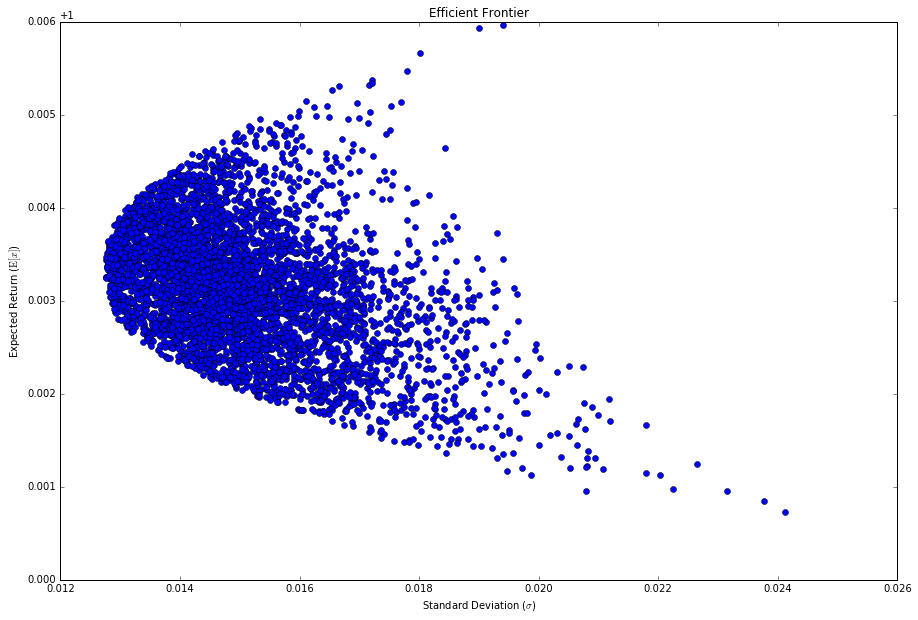

In [5]:
# Number of random portfolios we want to randomly generate
num_portfolios = 5000

# Seeded so we can replicate the results
np.random.seed(1)

means, stds = np.column_stack(
    [compute_mu_sigma(generate_random_portfolio()) for _ in range(num_portfolios)])

fig = plt.figure(figsize=(15,10))

# Plot the efficient frontier
plt.plot(stds, means, 'o')

plt.xlabel("Standard Deviation ($\sigma$)")
plt.ylabel("Expected Return ($\mathrm{E}[x]$)")
plt.title('Efficient Frontier')

plt.show()

# MVO Without Short Sales

* $\mathrm{E}[x] = \mu_1x_1 +...+ \mu_nx_n = \mu^Tx$
* $Var[x] = \sum_{i,j}\rho_{ij}\sigma_i\sigma_jx_ix_j = x^T\sum x$

## MVO Formulation (from class)

$$min\ x^TQx$$
$$s.t.\ \mu^Tx \ge R$$
$$e^Tx = 1$$
$$x \ge 0$$

## CVXOPT QP Solver

Solves problems in the form of:

$$min\ \frac{1}{2} x^TPx + q^Tx$$
$$s.t.\ Gx \le h$$
$$Ax = b$$

To map the current problem into the other form:

* $P = 2*Q$
* $q = \vec{0}$
* $A = I$
* $b = 1$
* $G = \begin{pmatrix}
  -\mu_1 & -\mu_2 & \cdots & -\mu_n \\
  -1 & 0 & \cdots & 0 \\
  0 & -1 & \cdots & 0 \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  0 & 0 & \cdots & -1 
 \end{pmatrix}$
 
* $h = \begin{pmatrix}
-R \\
0 \\
0 \\
\vdots \\
0
\end{pmatrix}$


In [6]:
def mvo_no_shorts(rets, m):
    K = len(keys)
    rets = np.asmatrix(rets)
    mu = np.mean(rets, axis=1)
    
    P = np.cov(rets)
    q = [0.0 for _ in range(K)]
    
    # Calling np.transpose on -1.0*mu results in a (K,) array, 
    # we want a (1, K) so we add it to a (1, K) array of zeros
    ret_cond = np.zeros((1, K)) + np.transpose(-1.0*mu)
    G = np.concatenate((ret_cond, -np.eye(K)), axis=0)
    
    # cvxopt complains if m is an integer
    h = [float(-m)] + [0.0 for _ in range(K)]
    
    A = np.ones((1, K))
    b = [1.0]

    sol = cvxopt.solvers.qp(
        cvxopt.matrix(2*P),
        cvxopt.matrix(q),
        cvxopt.matrix(G),
        cvxopt.matrix(h),
        cvxopt.matrix(A),
        cvxopt.matrix(b)
    )
    return sol['x']


In [7]:
# Allocations to achieve a certain portfolio value
allocation = mvo_no_shorts(returns_array, 1.006)
print list(allocation)
print compute_mu_sigma(allocation)

[0.9351732680845283, 2.3076910175156388e-07, 0.06482233969712932, 4.161449240665152e-06]
(1.0060000007049918, 0.019118818456217469)


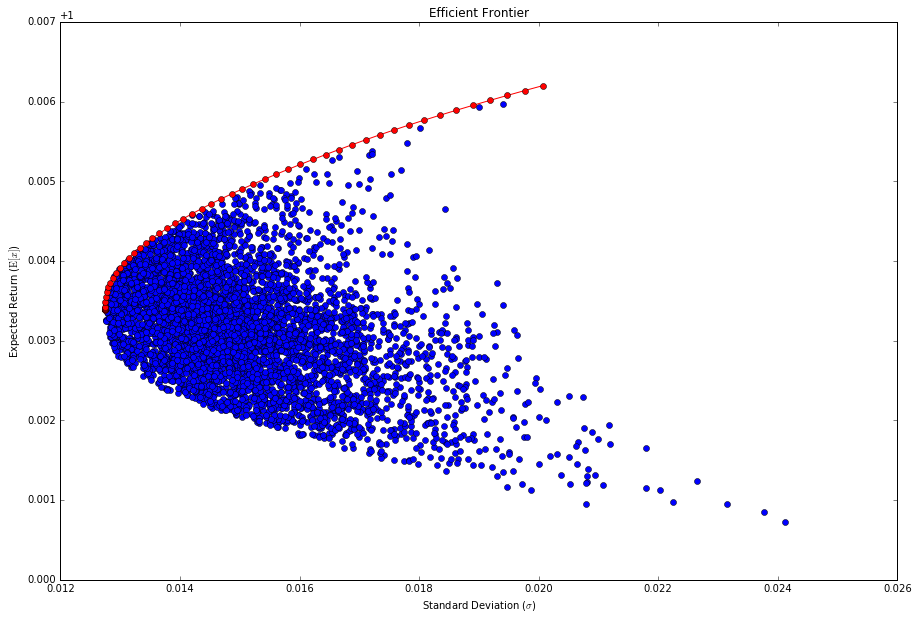

In [8]:
fig = plt.figure(figsize=(15,10))


e_r = np.mean(returns_array, axis=1)
steps = np.linspace(min(e_r), max(e_r), num=100)
allocations = [list(mvo_no_shorts(returns_array, s)) for s in steps]
means1, stds1 = np.column_stack([compute_mu_sigma(alloc) for alloc in allocations])


plt.plot(stds, means, 'o')
plt.plot(stds1, means1, 'r-o')

plt.xlabel("Standard Deviation ($\sigma$)")
plt.ylabel("Expected Return ($\mathrm{E}[x]$)")
plt.title('Efficient Frontier')

plt.show()

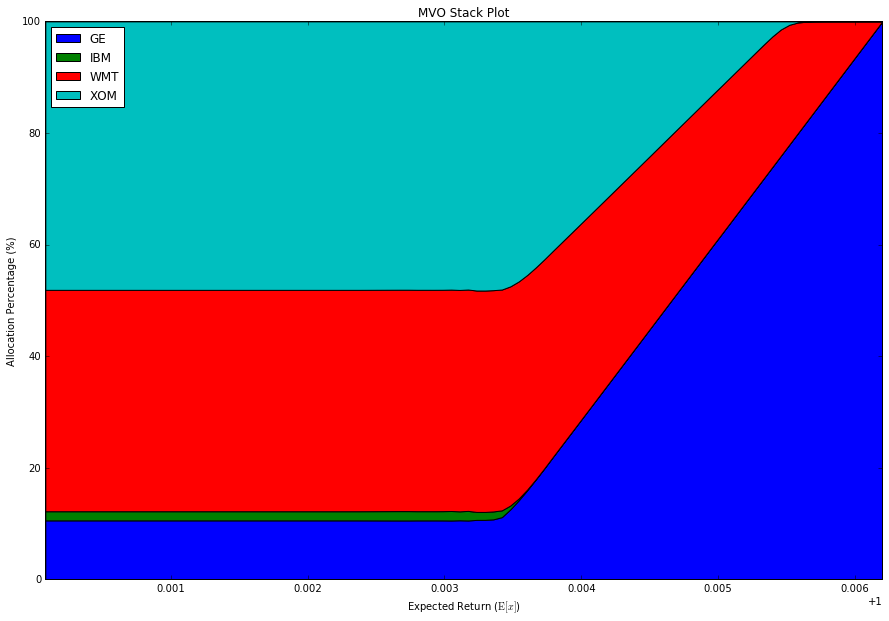

In [9]:
# Plot a stacked version of the allocations
from matplotlib.patches import Rectangle
y = np.column_stack(allocations)

percent = y /  y.sum(axis=0) * 100

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

stack_plt = ax.stackplot(steps, percent)
ax.set_title('MVO Stack Plot')
ax.set_ylabel('Allocation Percentage (%)')
ax.set_xlabel('Expected Return ($\mathrm{E}[x]$)')
ax.margins(0, 0) # Set margins to avoid "whitespace"
proxy_rects = [Rectangle((0, 0), 1, 1, fc=pc.get_facecolor()[0]) for pc in stack_plt]
ax.legend(proxy_rects, keys, loc='upper left')
plt.show()

# MVO with Short Sales

$$min\ x^TQx$$
$$s.t.\ \mu^Tx \ge R$$
$$e^Tx = 1$$

* We no longer have the constraint of $x_i \ge 0\ \forall i$

Which similarily becomes:
* $P = 2*Q$
* $q = \vec{0}$
* $A = I$
* $b = 1$
* $G = \begin{pmatrix}
  -\mu_1 & -\mu_2 & \cdots & -\mu_n \\
 \end{pmatrix}$
 
* $h = \begin{pmatrix}
-R \\
\end{pmatrix}$





In [10]:
def mvo_shorts(rets, m):
    K = len(keys)
    rets = np.asmatrix(rets)
    mu = np.mean(rets, axis=1)
    
    P = np.cov(rets)
    q = [0.0 for _ in range(K)]
    
    # Calling np.transpose on -1.0*mu results in a (K,) array, 
    # we want a (1, K) so we add it to a (1, K) array of zeros
    G = np.zeros((1, K)) + np.transpose(-1.0*mu)
    
    # cvxopt complains if m is an integer
    h = [float(-m)]
    
    A = np.ones((1, K))
    b = [1.0]

    sol = cvxopt.solvers.qp(
        cvxopt.matrix(2*P),
        cvxopt.matrix(q),
        cvxopt.matrix(G),
        cvxopt.matrix(h),
        cvxopt.matrix(A),
        cvxopt.matrix(b)
    )
    return sol['x']

In [11]:
allocation = mvo_shorts(returns_array, 1.008)
print list(allocation)
print compute_mu_sigma(allocation)

[1.0463900386547145, -0.5464150139703808, 0.2179877181403501, 0.2820372571753163]
(1.008000034885854, 0.021712639942615242)


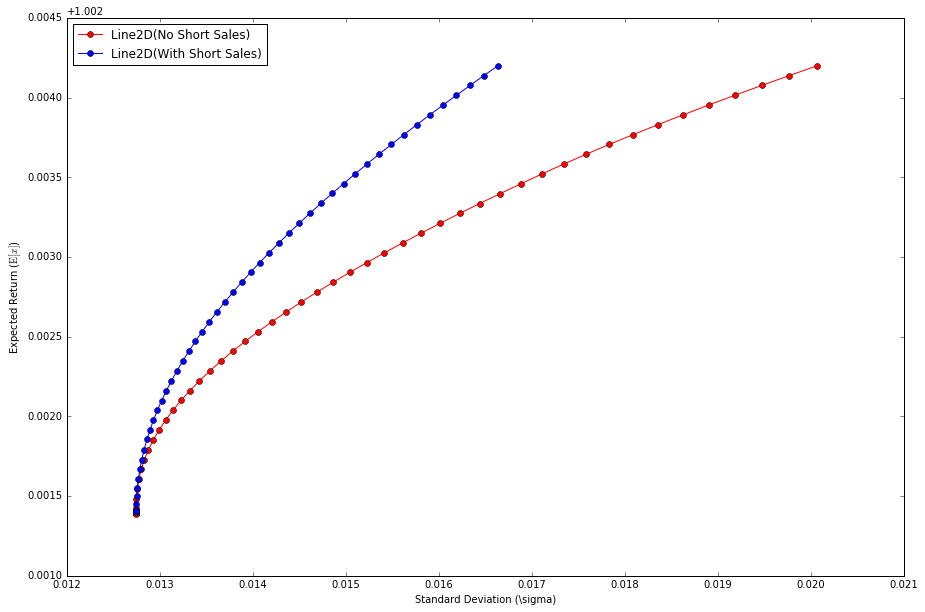

In [12]:
allocations = [list(mvo_shorts(returns_array, s)) for s in steps]
means2, stds2 = np.column_stack([compute_mu_sigma(alloc) for alloc in allocations])

fig = plt.figure(figsize=(15,10))
h1, = plt.plot(stds1, means1, 'r-o', label='No Short Sales')
h2, = plt.plot(stds2, means2, 'b-o', label='With Short Sales')
plt.xlabel('Standard Deviation (\sigma)')
plt.ylabel('Expected Return ($\mathrm{E}[x]$)')
plt.legend([h1, h2], loc='upper left', numpoints=1)

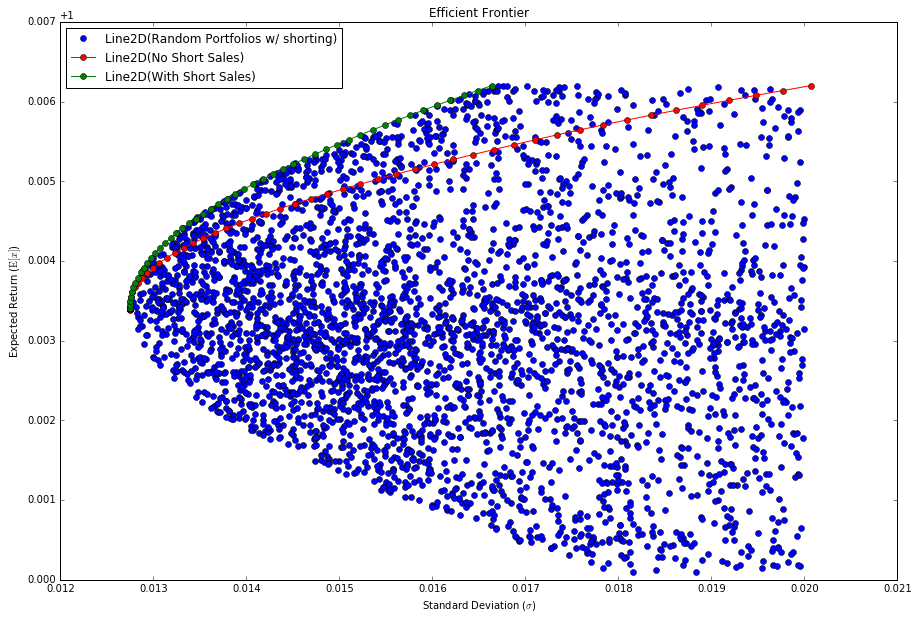

In [13]:
def generate_rnd_port():
    N = len(keys)
    # np.random.rand returns a 1xN matrix of values between [0.0, 1.0)
    allocations = 2*np.random.rand(N)-1
    allocations /= sum(allocations)
    return allocations

# Number of random portfolios we want to randomly generate
num_portfolios = 10000

# Seeded so we can replicate the results
np.random.seed(1)

# I am filtering out some of the samples so everything is in the same range
means3, stds3 = np.column_stack(filter(lambda x: x[0] < max(e_r) and x[0] > min(e_r) and x[1] < 0.02, 
    [compute_mu_sigma(generate_rnd_port()) for _ in range(num_portfolios)]))

fig = plt.figure(figsize=(15,10))

# Plot the efficient frontier
h0, = plt.plot(stds3, means3, 'o', label='Random Portfolios w/ shorting')
h1, = plt.plot(stds1, means1, 'r-o', label='No Short Sales')
h2, = plt.plot(stds2, means2, 'g-o', label='With Short Sales')

plt.xlabel("Standard Deviation ($\sigma$)")
plt.ylabel("Expected Return ($\mathrm{E}[x]$)")
plt.title('Efficient Frontier')
plt.legend([h0, h1, h2], loc='upper left', numpoints=1)

plt.show()